In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd
from scipy.stats import linregress, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm

import plot
from select_complex import Constraints, get_top_structure


simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()

# Set input files and directories
DGE_FILE = '../data/dge/dge.txt'
SITES_FILE = '../results/site_predictions/sites.txt'
STRUCT_DIR = '../results/RNAsubopt/'

# Set output directory for plots
FIG_DIR = '../results/graphs/FIG5/'

# Set color palette for plots
DIST_PALETTE = ['#000000', '#023eff', '#00d7ff', '#f14cc1', '#e8000b']

## Fig. 5A

  0%|          | 0/1052 [00:00<?, ?it/s]

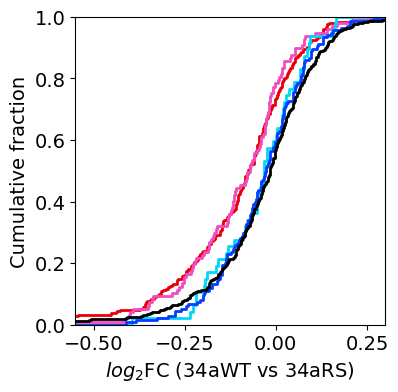

p = 3.1e-08 (ANOVA)

group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    14  14+16  -0.0117 0.9922 -0.0843  0.0609  False
    14     16  -0.0677 0.0108 -0.1247 -0.0106   True
    14  No 3P  -0.0026 0.9998 -0.0439  0.0388  False
    14  No GU  -0.0694 0.0004 -0.1153 -0.0235   True
 14+16     16   -0.056 0.2631 -0.1322  0.0202  False
 14+16  No 3P   0.0091 0.9955 -0.0561  0.0744  False
 14+16  No GU  -0.0577 0.1423 -0.1259  0.0105  False
    16  No 3P   0.0651 0.0017  0.0177  0.1125   True
    16  No GU  -0.0017    1.0 -0.0531  0.0496  False
 No 3P  No GU  -0.0668    0.0 -0.0999 -0.0337   True


  GU pairs  count
0    No 3P    526
2       14    135
4    14+16     47
3       16     97
1    No GU    247 



<Figure size 400x400 with 0 Axes>

In [2]:
# Read data: genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)
# Keep genes significantly downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]

# Predict structures with GU pairing allowed to g14 and g16
constraints = Constraints(
    force_paired=({13}, {14},),
    min_pairs=3, offset=(-4, 4), max_mm_count=0,
    no_gu_bases=(8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 22,))
cols = ['3P start', 'Target pairs', 'miRNA pairs', 'MFE',
        'Offset', 'GU pairs']
data[cols] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints,), axis=1)


x_var = 'log2fc WT-RS'
hue = 'GU pairs'
groups = ['No 3P', '14', '14+16', '16', 'No GU']

data[hue] = data.apply(
    lambda x: 'No 3P' if pd.isnull(x['3P start'])
    else 'No GU' if not x['GU pairs']
    else '+'.join([str(i) for i in x['GU pairs']]), axis=1)

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups, palette=DIST_PALETTE,
    xlim=(-0.55, 0.3), xticks=(-0.5, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)',
    outfile=FIG_DIR+'5A')

model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')

  0%|          | 0/1052 [00:00<?, ?it/s]

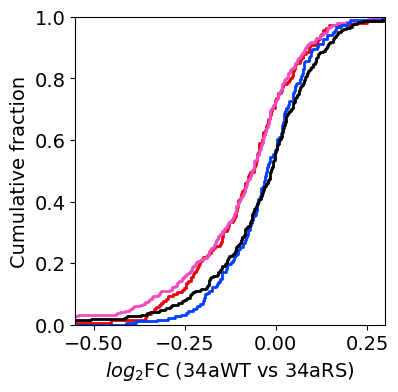

p = 1.4e-07 (ANOVA)

group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    14  No 3P  -0.0095 0.9025 -0.0453  0.0262  False
    14  No GU  -0.0529 0.0148 -0.0983 -0.0075   True
    14 Not 14  -0.0692    0.0 -0.1073 -0.0311   True
 No 3P  No GU  -0.0434 0.0235 -0.0826 -0.0041   True
 No 3P Not 14  -0.0596    0.0 -0.0902 -0.0291   True
 No GU Not 14  -0.0163 0.7426 -0.0577  0.0251  False


  GU pairs  count
0    No 3P    433
2       14    182
1   Not 14    296
3    No GU    141 



<Figure size 400x400 with 0 Axes>

In [3]:
# Genes with =1 site
data = pd.read_csv(DGE_FILE, sep='\t')
sites = pd.read_csv(SITES_FILE, sep='\t')
data = pd.merge(data, sites)
data.drop_duplicates(subset='Gene ID', keep=False, inplace=True)
# Genes downregulated by 34aWT
data = data[(data['log2fc WT-NC'] < 0) & (data['FDR WT-NC'] < 0.05)]

constraints = Constraints(
    force_paired=({13}, {14},), min_pairs=3, offset=(-4, 4), max_mm_count=0)

cols = ['3P start', 'Target pairs', 'miRNA pairs', 'MFE',
        'Offset', 'GU pairs']
data[cols] = data.progress_apply(
    get_top_structure, args=(STRUCT_DIR, constraints,), axis=1)

data['GU pairs'] = data.apply(
    lambda x: 'No 3P' if pd.isnull(x['3P start'])
    else 'No GU' if not x['GU pairs']
    else '14' if 14 in x['GU pairs'] else 'Not 14', axis=1)


x_var = 'log2fc WT-RS'
hue = 'GU pairs'
groups = ['No 3P', '14', 'Not 14', 'No GU']

plot.cumulative_hist(
    data, x=x_var, hue=hue, hue_order=groups,
    palette=DIST_PALETTE[:2]+DIST_PALETTE[-2:],
    xlim=(-0.55, 0.3), xticks=(-0.5, 0.25, 0.25),
    xlabel='$log_{2}$FC (34aWT vs 34aRS)',
    outfile=FIG_DIR+'5B')

model = f_oneway(*[data[data[hue] == i][x_var] for i in groups])
print('p =', plot.round_value(model.pvalue, 2), '(ANOVA)\n')

hsd = pairwise_tukeyhsd(endog=data[x_var], groups=data[hue], alpha=0.05)
print(*str(hsd.summary()).split('\n')[2:-1], sep='\n')
print('\n')

counts = data[hue].value_counts().reset_index()
counts.sort_values(hue, key=np.vectorize(groups.index), inplace=True)
print(counts, '\n')